The first 3 cells are from codes provided in the [paper](https://arxiv.org/pdf/2003.03468.pdf) "Characterizing the radio quiet region behind the lunar farside for low radio frequency experiments." by Bassett, Neil, et al.

Details of the code can be found [here](https://bitbucket.org/nbassett/lunar-rfi/src/master/)which uses finite-difference time-domain method to simulate radio waves propogating around Moon.

The calc_width function is the only function that I will be using. It takes 3 arguments as inputs <br>
1 $\nu$ (nu) which is the frequecny of wave in kHz. In our case I find the extent of cone for 30 MHz ($30\times 10^3$ kHz) and 250 MHz ($250\times 10^3$ kHz)<br>
2 h which is the height above the lunar surface in km. I find the extent of quiet cone for maximum allowed height of 150 km with a fixed step size<br>
3 db which represents the attenuation required. For our case I take the maximum allowed value of attenuation (-90 dB) <br>

The `calc_width` function returns width of the quiet cone in degrees and the error associated with it. <br>
Naturally the quiet cone is centered at farside around the line joining centre of Moon to centre of Earth. This line is not fixed with respect to surface of the Moon and varies slightly throughtout the year. Thus the quiet cone shifts slightly in a year with respect to lunar surface. **The cone is fixed in Earth_X system** and all plots of width of quiet cone generated in cells below are in Earth_X system.

---

# Calculating Width of Quiet Region #

This folder contains Python functions which use the numerical results 
of FDTD simulations to quickly calculate the size of the radio quiet cone.
The width of the quiet region depends on three parameters:

* ν: frequency (in kHz)
* h: height above in the lunar surface (0 km <= h <= 150 km)
* dB: the relative intensity threshold for the quiet region (-90 <= dB <= -50)

### Running scripts ###

The `calc_width` will likely be the only function that you will need to use directly. This function will return the width of the quiet region along with a +/- 
uncertainty in degrees given the three input parameters listed above. If the calculated width is negative, the function will return 0. An example of how to use 
the `calc_width` function is shown in the `example_calc_width.py` script.

In [1]:
"""
File: load_2d_interp.py
Author: Neil Bassett
Date: 20 Aug 2019

Description: Contains functions which load interpolations of height vs. dB
             threshold grid for the coefficients a and b in the power law
             a*(nu**b) where nu is the frequency. Grid was calculated 
             from fits to FDTD simulations of RFI diffraction around the moon.
"""
from __future__ import division
import numpy as np
import pickle
from scipy.interpolate import interp2d

def load_interp_2d():
    """
    Loads interpolation of h vs. dB grid for a and b power law parameters
    from 2d_interp_h_vs_dB.pkl
    """
    f = open('2d_interp_h_vs_dB.pkl', 'rb')
    interp_dict = pickle.load(f)
    f.close()
    return interp_dict['a_grid_interp'],\
           interp_dict['b_grid_interp']


In [2]:
"""
File: calc_width.py
Author: Neil Bassett
Date: 20 Aug 2019

Description: Contains function to calculate the width of the radio quiet region
             given the frequency, height above the lunar surface, and intensity
             threshold in dB.
"""
from __future__ import division
import numpy as np
from load_interp_2d import load_interp_2d

def geom_width(h):
    """
    Calculates width of quiet from pure geometry (i.e. ignoring diffraction)

    h: height above the surface of the Moon in km 
    """
    r_moon = 1737.1
    r_earth = 6371
    d = 384400
    slope = (r_earth - r_moon)/d
    A = 1 + (slope**2)
    B = -2*(slope*r_moon)
    C = (r_moon**2) - ((r_moon + h)**2)
    root1 = (-B + np.sqrt((B**2) - 4*A*C))/(2*A)
    root2 = (-B - np.sqrt((B**2)- 4*A*C))/(2*A)
    if root1 > 0:
        x = root1
    else:
        x = root2
    y = np.sqrt((r_moon + h)**2 - x**2)
    angle = np.arctan(y/x)
    return 2*angle*(180./np.pi)

def width_pwr_law(nu, h, a, b):
    """
    Defines power law model for the width of the quiet region as a function
    of frequency. Offset is determined by geometric width which is the
    behavior at infinite frequency.

    nu: frequency in kHz
    h: height above lunar surface in km
    a: coefficient, may be calculated from interpolation of h vs dB grid
    b: coefficient, may be calculated from interpolation of h vs dB grid
    """
    return geom_width(h) - a*(nu**b)

def calc_width(nu, h, dB):
    """
    Calculates width of quiet cone given frequency, height, and dB threshold

    nu: frequency in kHz
    h: height above lunar surface in km (0 <= h <= 150)
    dB: quiet region intensity threshold in dB (-90 <= dB <= -50)

    returns: best estimate of width of quiet region (in degrees) with
             plus and minus uncertainties
    """
    #if (h < 0 or h > 150 or dB < -90 or dB > -50):
    #    raise ValueError('Parameters not within appropriate bounds!')
    a_interp, b_interp = load_interp_2d()
    best_fit = width_pwr_law(nu, h, a_interp(h, dB)[0], b_interp(h, dB)[0])
    plus_uncert = width_pwr_law(nu, h, a_interp(h, dB)[0] - 7,\
                                b_interp(h, dB)[0] - 0.01) - best_fit
    minus_uncert = best_fit - width_pwr_law(nu, h, a_interp(h, dB)[0] + 7,\
                                            b_interp(h, dB)[0] + 0.01)
    if (best_fit < 0):
        best_fit = minus_uncert = 0
        plus_uncert = max(0, best_fit + plus_uncert)
    return best_fit, plus_uncert, minus_uncert


In [3]:
"""
File: example_load_2d_interp.py
Author: Neil Bassett
Date: 20 Aug 2019

Description: Example of how to use calc_width.py to calculate the width of the
             radio quiet region given the frequency, height, and dB threshold.
"""
from calc_width import calc_width

nu = 175 #kHz
h = 50 #km above surface
dB = -85 #intensity threshold
width, plus, minus = calc_width(nu, h, dB)
print('Freq = %.1f kHz, h = %.1f km, threshold = %.1f dB:' % (nu, h, dB))
print('Width of radio quiet region = %.2f +%.2f/-%.2f deg'\
      % (width, plus, minus))


Freq = 175.0 kHz, h = 50.0 km, threshold = -85.0 dB:
Width of radio quiet region = 118.43 +2.34/-2.50 deg


---

All the cells below are my work

In [6]:
nu = float(input("frequency in KHz "))                
h = float(input("height in Km "))      
dB = float(input("intensity threshold in dB "))             

width, plus, minus = calc_width(nu, h, dB)

print('Freq = %.1f kHz, h = %.1f km, threshold = %.1f dB:' % (nu, h, dB))
print('Width of radio quiet region = %.2f +%.2f/-%.2f deg'\
      % (width, plus, minus))



frequency in KHz 175
height in Km 50
intensity threshold in dB -85
Freq = 175.0 kHz, h = 50.0 km, threshold = -85.0 dB:
Width of radio quiet region = 118.43 +2.34/-2.50 deg


Since the cone is centerd around the $180^o$ longitude in `Earth_X system`, I find the longitude of boundary of quiet cone at diiferent heights using a function cone_long(). In accounting the errors I take the worst case scenarios.

In [7]:
def cone_long(freq, h, dB):
    width, plus, minus = calc_width(freq, h, dB)
    
    llong, ulong =180-((width-minus)/2) , 180+((width-minus)/2)
    
    return llong, ulong, dB



## one frequency all attenuations

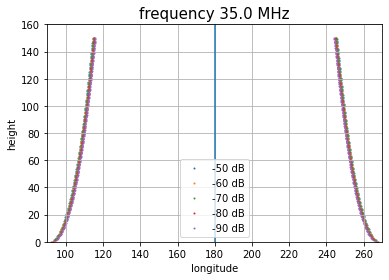

In [9]:
import matplotlib.pyplot as plt
import pandas as pd



df= pd.DataFrame( columns= ["Height","dB","Llong","Ulong"])



freq= 35000 # kHz
dB= -80

h=np.linspace(0,150,150) # array of heights 

plt.xlabel("longitude")
plt.ylabel("height")
plt.title("frequency "+str(freq/1000)+ " MHz", fontsize=15)
plt.grid()

plt.xticks(ticks= np.arange(0,360,20))
plt.axvline(x=180)
plt.xlim((90,270))
plt.ylim((0,160))


#colours for    -90, -80, -70, -60, -50
c=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for (att, c_pos) in zip(range(-50,-100,-10),range(0,5,1)):
    for height in h:
        llong, ulong, dB= cone_long(freq, height, att)
        df= df.append({"Height": height,"dB":att, "Llong": llong, "Ulong": ulong}, ignore_index=True)
        if (np.floor(height)==0):
            plt.scatter([llong,ulong],[height,height], c=c[c_pos], s=1, label=str(dB)+" dB")
        else:    
            plt.scatter([llong,ulong],[height,height], c=c[c_pos], s=1)
    
plt.legend()


df.to_excel("Radio_cone_1freq.xlsx", index= None)

## Plotting min cone size at upper and lower limit of frequency band and maximum attenuation of -90 dB 
## storing height vs longitude values in an excel file

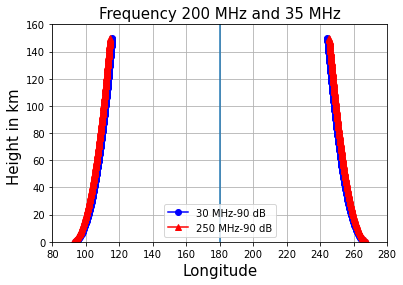

In [6]:
total= 300 # total steps from 0 km to 150 km
heights=np.linspace(0, 150, total) # to store height values

x_vals=np.zeros(total*2)      # to store long values
y_vals=np.zeros(total*2)    # to store height values of points

#------------------------------------------



#-------------------------------------------
msg= "Frequency 200 MHz and 35 MHz"
plt.xlabel("Longitude", fontsize=15)
plt.ylabel("Height in km ", fontsize=15)
plt.title(msg, fontsize=15)
plt.grid()
plt.xticks(ticks= np.arange(0,360,20))
plt.axvline(x=180)
plt.xlim((80,280))
plt.ylim((0,160))


freqs=[30, 250] # upper and lower limit of frequency band


#-------------------------------------------

import pandas as pd

a=np.zeros((total, 5))
df= pd.DataFrame(data=a, columns= ["Height","Llong_30","Ulong_30","Llong_250","Ulong_250"])


#-------------------------------------------


    
att=-90
    
for pos in range(np.size(heights)):
    for freq in freqs:

        freq*=1000  # converting to kHz
        llong, ulong, att=cone_long(freq, heights[pos], att)
        x_vals[pos]= llong
        x_vals[-(pos+1)]= ulong
        y_vals[pos]= heights[pos]
        y_vals[-(pos+1)]= heights[pos]

        if freq==freqs[0]*1000:
            df.iloc[pos, 0]= heights[pos]
            df.iloc[pos, 1]= llong
            df.iloc[pos ,2]= ulong
        else:
#             df.iloc[pos, 0]= heights[pos] # height column has already been filled
            df.iloc[pos, 3]= llong
            df.iloc[pos ,4]= ulong


plt.plot(df.iloc[:,1], df.iloc[:,0], color= "blue",marker= "o", label= str(freqs[0])+" MHz"+ str(att)+" dB")
plt.plot(df.iloc[:,2], df.iloc[:,0], color= "blue",marker= "o")



plt.plot(df.iloc[:,3], df.iloc[:,0], color= "red",marker= "^", label= str(freqs[1])+" MHz"+ str(att)+" dB")
plt.plot(df.iloc[:,4], df.iloc[:,0], color= "red",marker= "^")

 #-------------------------------------------




plt.legend()
plt.show()


df.to_excel("Radio_cone_width.xlsx", index= None)